# Stock Market News Analysis

**Purpose:** *This report examines the news published on stocks of publicly traded companies*

**Scope:** *Focuses on publicly traded companies*

**Methodology:** *Sentimental Analysis and Trend Analysis* 

In [1]:
# from news_analysis_module import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import calendar
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import string
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from IPython.display import display,HTML

In [2]:
# load dataset
raw = pd.read_csv("raw_analyst_ratings.csv")

In [3]:
# getting information on the dataset
raw.shape

(1407328, 6)

In [4]:
# getting information on the dataset
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


In [5]:
# removing the Unnamed:0 column
raw.drop(columns=['Unnamed: 0'], axis = 1,inplace = True)

In [6]:
# viewing the first 5 rows of the dataset
raw.head()

,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


## Preprocessing

> Some messiness found in the dataset:
-  Duplicates headlines thus have the same headlines, publisher and date.
- Emails as publisher names.
- Dates with '04:00: time zone

In [7]:
# copying the dataset
df = raw.copy()

In [8]:
# length of headlines
df['headline_length'] = df['headline'].apply(len)  
df[df['headline_length'] < 10]

,headline,url,publisher,date,stock,headline_length
17629,Accenture,https://www.benzinga.com/11/06/1205410/accenture,Investor's Business Daily,2011-06-27 00:00:00,ACN,9
34857,X Games,https://www.benzinga.com/general/10/08/434477/...,inthemoneystocks,2010-08-18 00:00:00,AEO,7
34858,X Games,https://www.benzinga.com/general/10/08/434476/...,inthemoneystocks,2010-08-18 00:00:00,AEO,7
45470,Gold Rush,https://www.benzinga.com/news/global/12/02/235...,inthemoneystocks,2012-02-21 00:00:00,AGQ,9
45732,Adecoagro,https://www.benzinga.com/trading-ideas/12/03/2...,Investor's Business Daily,2012-03-29 00:00:00,AGRO,9
83529,USO to Go,https://www.benzinga.com/11/05/1063876/uso-to-go,Market Rewind,2011-05-06 00:00:00,AP,9
127835,Amgen,https://www.benzinga.com/trading-ideas/12/04/2...,Investor's Business Daily,2012-04-02 00:00:00,AZN,5
156863,X Games,https://www.benzinga.com/general/10/08/434477/...,inthemoneystocks,2010-08-18 00:00:00,BHP,7
156864,X Games,https://www.benzinga.com/general/10/08/434476/...,inthemoneystocks,2010-08-18 00:00:00,BHP,7
156997,FTSE 100,https://www.benzinga.com/wallstreet1928/2009/9...,wallstreet1928,2009-09-14 00:00:00,BHP,8


> The headlines of these rows are short and can be used as a threshold to cut the dataset.

In [9]:
# remove duplicates
duplicated_values = df.duplicated(subset=['headline','publisher','date']).sum()
print(f"Number of duplicates: {duplicated_values}")

df_cleaned = df.drop_duplicates(subset=['headline','publisher','date'], keep = 'first') # dataframe with no duplicate values
df_cleaned.shape

Number of duplicates: 515690


(891638, 6)

In [10]:
# remove headline line with a threshold headline length above 10
threshold = 10
df_cleaned = df_cleaned[df_cleaned['headline_length'] > threshold]
df_cleaned.shape   # reduced the shape of the dataset to work on from (1407328, 6) to (891579, 6)

(891579, 6)

In [11]:
# check for publisher with domain name 
domain = r'\b(?:[a-zA-Z0-9-]+\.)+[a-zA-Z]{2,6}\b'
df_cleaned['publisher_domain'] = df_cleaned['publisher'].apply(lambda x: bool(re.search(domain,x)))
df_cleaned[df_cleaned['publisher_domain']].any()

headline            True
url                 True
publisher           True
date                True
stock               True
headline_length     True
publisher_domain    True
dtype: bool

In [12]:
# extract the publisher name from publishers with domanin name
def extract_publisher_name(publisher):
    match = re.search(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', publisher)
    if match:
        return match.group(0).split('@')[0]
    
    else: 
        return publisher

In [13]:
# extracting the publisher names from domain publishers
df_cleaned['publisher'] = df_cleaned['publisher'].apply(extract_publisher_name) 

In [14]:
# dates with timezone
inconsistent_pattern = r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}-\d{2}:\d{2}'   
inconsistent = df_cleaned['date'].str.match(inconsistent_pattern)
inconsistent.any()

True

In [15]:
# removing the timezone
inconsistent_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})-\d{2}:\d{2}'   
df_cleaned['date_time'] = df_cleaned['date'].str.replace(inconsistent_pattern, r'\1', regex = True)

# check 
pattern = r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}-\d{2}:\d{2}'   
pattern = df_cleaned['date_time'].str.match(pattern)
pattern.any()

False

## Descriptive Statistics

In [16]:
# Top ten headline length 
df_cleaned.sort_values(by='headline_length',ascending=False)[['headline','publisher','headline_length']].head(10)

,headline,publisher,headline_length
701748,JinkoSolar Tiger Pro Series Receives World's F...,Charles Gross,512
238137,Check Point® Software Technologies Ltd. (NASDA...,Charles Gross,509
140048,Shares of several financial services companies...,Benzinga Newsdesk,458
39028,Shares of several financial services companies...,Benzinga Newsdesk,458
110398,Shares of several silver and gold companies ar...,Benzinga Newsdesk,425
32950,Shares of several precious metals companies ar...,Benzinga Newsdesk,423
72008,Shares of several companies in the financial s...,Benzinga Newsdesk,410
219278,Shares of several real estate companies and RE...,Benzinga Newsdesk,408
199600,Shares of several real estate companies and RE...,Benzinga Newsdesk,408
67373,Shares of several oil and gas companies are tr...,Benzinga Newsdesk,401


In [17]:
# Botttom ten headline length 
df_cleaned.sort_values(by='headline_length',ascending=False)[['headline','publisher','headline_length']].tail(10)

,headline,publisher,headline_length
124221,Cloning 101,AlphaClone,11
322771,Cement ETF?,Roger Nusbaum,11
146145,Sectorology,Roger Nusbaum,11
1394007,Yahoo at 20,Mike Butler,11
65040,Excess Cash,David Trainer,11
26219,EX-DIVIDEND,Benzinga Staff,11
1081608,Sexy Stocks,Fred Fuld,11
1379594,Hey Abbott!,Roger Nusbaum,11
404225,Rolling EDC,webmaster,11
1377429,Apple Mania,Market Rewind,11


In [18]:
# Top publishers
df_cleaned.groupby('publisher')['headline'].count().sort_values(ascending = False).head(10)

publisher
Paul Quintaro        211677
Benzinga Newsdesk     95479
Charles Gross         83764
Eddie Staley          54172
Hal Lindon            44075
Lisa Levin            31179
Monica Gerson         28083
Juan Lopez            27856
Vick Meyer            24822
Benzinga Staff        23454
Name: headline, dtype: int64

In [19]:
# The last ten publishers
df_cleaned.groupby('publisher')['headline'].count().sort_values(ascending = False).tail(10)

publisher
HedgeCoVest             1
Hasan Saleem            1
Happy Trading           1
Ticker Tank             1
Growth Aces             1
Greg W. Harmon          1
Gold Investment         1
Goatmug Blog            1
GlobalCoinReport.com    1
GeoInvesting            1
Name: headline, dtype: int64

In [20]:
# top 10 publicly traded companies
df_cleaned.groupby('stock')['headline'].count().sort_values(ascending = False).head(10)

stock
AA      2714
EWU     2574
BABA    2506
EBAY    2274
BBRY    2215
AGN     2120
GILD    2001
DAL     1952
ADBE    1891
CMG     1884
Name: headline, dtype: int64

In [21]:
# bottom 10 publicly traded company
df_cleaned.groupby('stock')['headline'].count().sort_values(ascending = False).tail(10)

stock
CTNN    1
JPGE    1
BLJ     1
PIM     1
DUC     1
JPC     1
IBCC    1
AUMA    1
JOF     1
SMLV    1
Name: headline, dtype: int64

### Trends over time

In [22]:
# split datetime to date and time column
df_cleaned['date_time'] = pd.to_datetime(df_cleaned['date_time'])
df_cleaned['date'] = df_cleaned['date_time'].dt.date
df_cleaned['time'] = df_cleaned['date_time'].dt.time

# extracting day, month and year
df_cleaned['day'] = df_cleaned['date_time'].dt.day
df_cleaned['month'] = df_cleaned['date_time'].dt.month
df_cleaned['year'] = df_cleaned['date_time'].dt.year

In [23]:
# function to plot line graph
def line_graph(x, y, width, height, title, x_label):
    plt.figure(figsize=(width,height))
    plt.plot(x , y)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel('Published headline')
    plt.show()

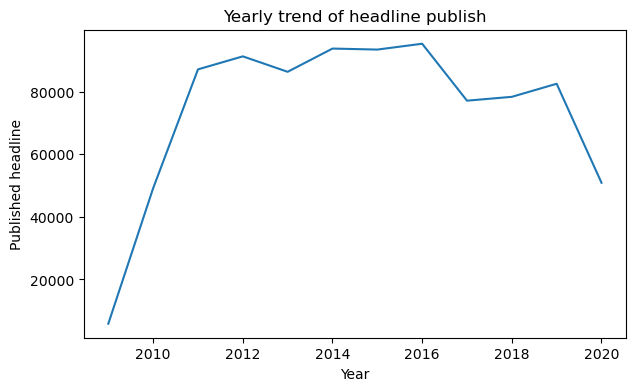

In [24]:
# per year trends graph
x = df_cleaned.groupby('year').count()['headline'].index.tolist()
y = df_cleaned.groupby('year').count()['headline'].tolist()

line_graph(x, y, 7, 4, 'Yearly trend of headline publish', 'Year')

In [25]:
# add month name column
def month_name(month_num):
    return calendar.month_name[month_num]

df_cleaned['month_name'] = df_cleaned['month'].apply(month_name)

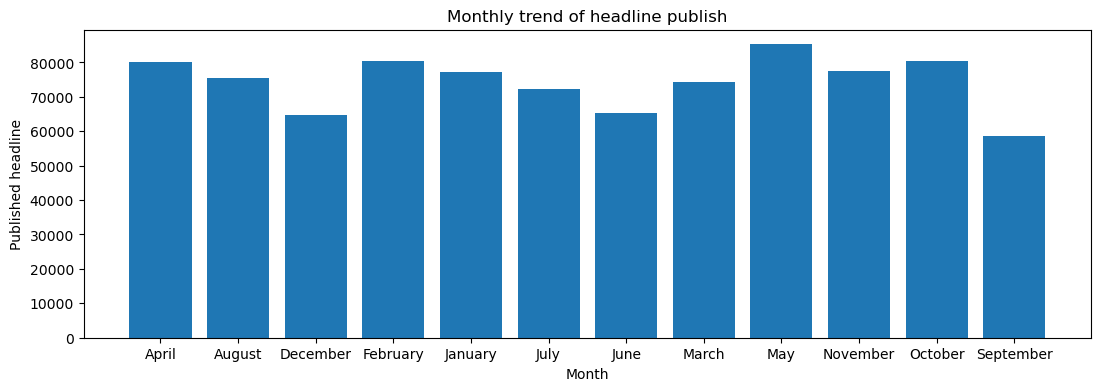

In [26]:
# per month trends
x = df_cleaned.groupby('month_name').count()['headline'].index.tolist()
y = df_cleaned.groupby('month_name').count()['headline'].tolist()

plt.figure(figsize=(13,4))
plt.bar(x , y)
plt.title('Monthly trend of headline publish')
plt.xlabel('Month')
plt.ylabel('Published headline')
plt.show()

In [27]:
# add day name column
df_cleaned['day_name'] = df_cleaned['date_time'].dt.day_name()


day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_cleaned.groupby('day_name').count()['headline']
day_counts.index = pd.Categorical(day_counts.index, categories=day_order, ordered=True)
day_counts_sorted = day_counts.sort_index()

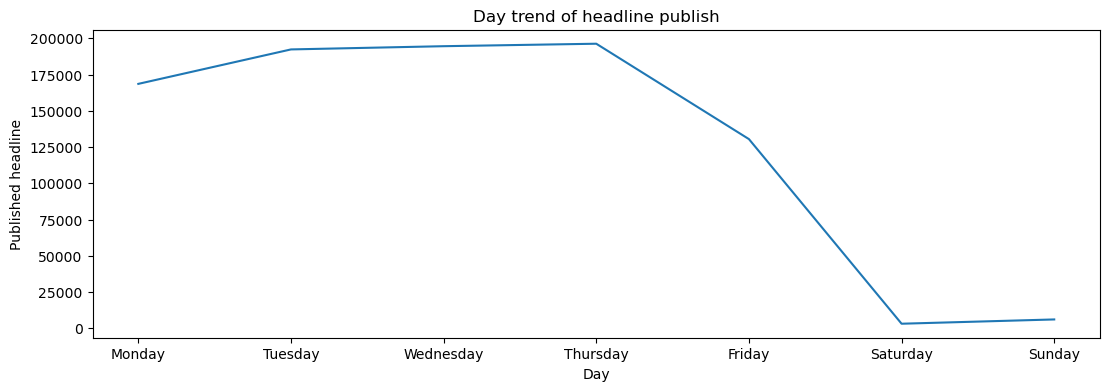

In [28]:
# per day trends
x = day_counts_sorted.index.tolist()
y = day_counts_sorted.tolist()

line_graph(x, y, 13, 4, 'Day trend of headline publish', 'Day')

## Text Analysis (sentimental analysis & Topic Modeling)

In [29]:
# download vader_lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [30]:
# create a new colum for the sentiment values then categorize it form very negative to positive
sentiment_analyzer = SentimentIntensityAnalyzer()
df_cleaned['sentiment'] = df_cleaned['headline'].apply(lambda x: sentiment_analyzer.polarity_scores(text=x)['compound'])
df_cleaned['sentiment_category'] = pd.cut(df_cleaned['sentiment'], bins=[-1, -0.5, -0.0001, 0.5, 1], labels=['Very Negative', 'Negative', 'Neutral', 'Positive'])

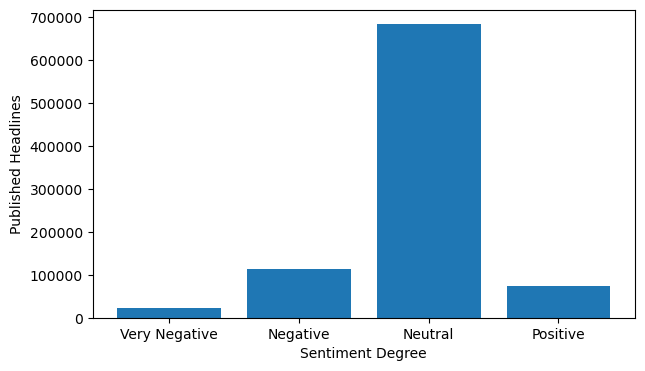

In [31]:
# Bar plots of the sentiments
headline_sentiments = df_cleaned.groupby('sentiment_category')['headline'].count()
x = headline_sentiments.index.tolist()
y = headline_sentiments.values.tolist()

plt.figure(figsize=(7,4))
plt.bar(x, y)
plt.xlabel('Sentiment Degree')
plt.ylabel('Published Headlines')
plt.show()

### NLP

In [32]:
# download stopwords and punkt
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
# function to do the NLP tasks
def preprocess_text(text):
    # instantiate Lemmatization
    lmtzr = WordNetLemmatizer()
    
    # instantiate stopwords and appending letter or words to be considered as stopword
    stop = stopwords.words('english')
    stop.append("est")
    stop.append(list(string.ascii_lowercase))
    stop.append("eps")
    stop.append("pt")
    stop.append("vs")
    
    text = text.lower()
    text = re.sub(r'^\w\s','',text)
    text = text.translate(text.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lmtzr.lemmatize(word) for word in tokens if word not in stop]

    return tokens


# sampling the dataframe since it contain almost 900000 rows
chunk = df_cleaned.sample(n=100000,random_state=42)
chunk['tokens'] = chunk['headline'].apply(preprocess_text)

# flatten the tokens to get the most frequent word
all_tokens = [word for tokens in chunk['tokens'] for word in tokens]

# using FreqDist to get the frequency of words
freq_dist = FreqDist(all_tokens)
print("Most common words:")
print(freq_dist.most_common(10))

print('\n')

# common phrases using bigrams
def bigrams(tokens):      # functions to get two phrases words
    bigram = nltk.ngrams(tokens,2)
    return [' '.join(grams) for grams in bigram]

chunk['bigrams'] = chunk['tokens'].apply(lambda tokens: bigrams(tokens))
all_bigrams = [bigram for bigrams in chunk['bigrams'] for bigram in bigrams]
bigram_freq = FreqDist(all_bigrams)
print("Most common bigrams:")
print(bigram_freq.most_common(20))   # 20 because to find common event

Most common words:
[('report', 12756), ('sale', 8870), ('share', 8807), ('announces', 7188), ('buy', 6825), ('update', 6784), ('raise', 6511), ('price', 6395), ('stock', 5894), ('maintains', 5839)]


Most common bigrams:
[('price target', 4886), ('initiate coverage', 3181), ('report q2', 1966), ('report q4', 1901), ('option alert', 1874), ('report q3', 1804), ('report q1', 1726), ('raise price', 1726), ('estimate sale', 1553), ('share trading', 1521), ('morgan stanley', 1497), ('lower price', 1467), ('jp morgan', 1383), ('maintains buy', 1352), ('deutsche bank', 1239), ('inc report', 1188), ('goldman sachs', 1079), ('trading higher', 1042), ('bank america', 1026), ('credit suisse', 999)]


# Time series analysis

In [34]:
# Ensure the time column is in datetime format (only if it's not already)
df_cleaned['time'] = pd.to_datetime(df_cleaned['time'], format='%H:%M:%S').dt.time

# creates a time category
def categorize_time(time):
    seconds = time.hour * 3600 + time.minute * 60 + time.second # change each time to second
    
    if seconds >= 0 and seconds < 10800:
        return 'midnight'
    
    elif seconds >= 10800 and seconds < 21600:
        return 'early morning'
    
    elif seconds >= 21600 and seconds < 43200:
        return 'morning'
    
    elif seconds == 43200:
        return 'noon'
    
    elif seconds > 43200 and seconds < 64800:
        return 'afternoon'
    
    else:
        return 'evening'

# Apply the function to the time column
df_cleaned['time_category'] = df_cleaned['time'].apply(categorize_time)


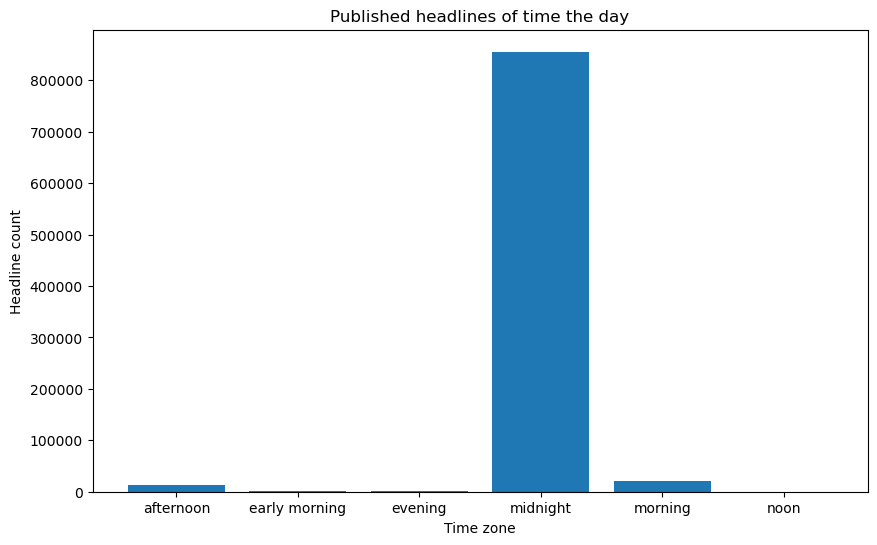

In [35]:
# group the datetime by time_catefory
df_grouped = df_cleaned.groupby('time_category').count()['headline']
x = df_grouped.index.tolist()
y = df_grouped.values

plt.figure(figsize = (10,6))
plt.bar(x, y)
plt.title('Published headlines of time the day')
plt.xlabel('Time zone')
plt.ylabel('Headline count')
plt.show()

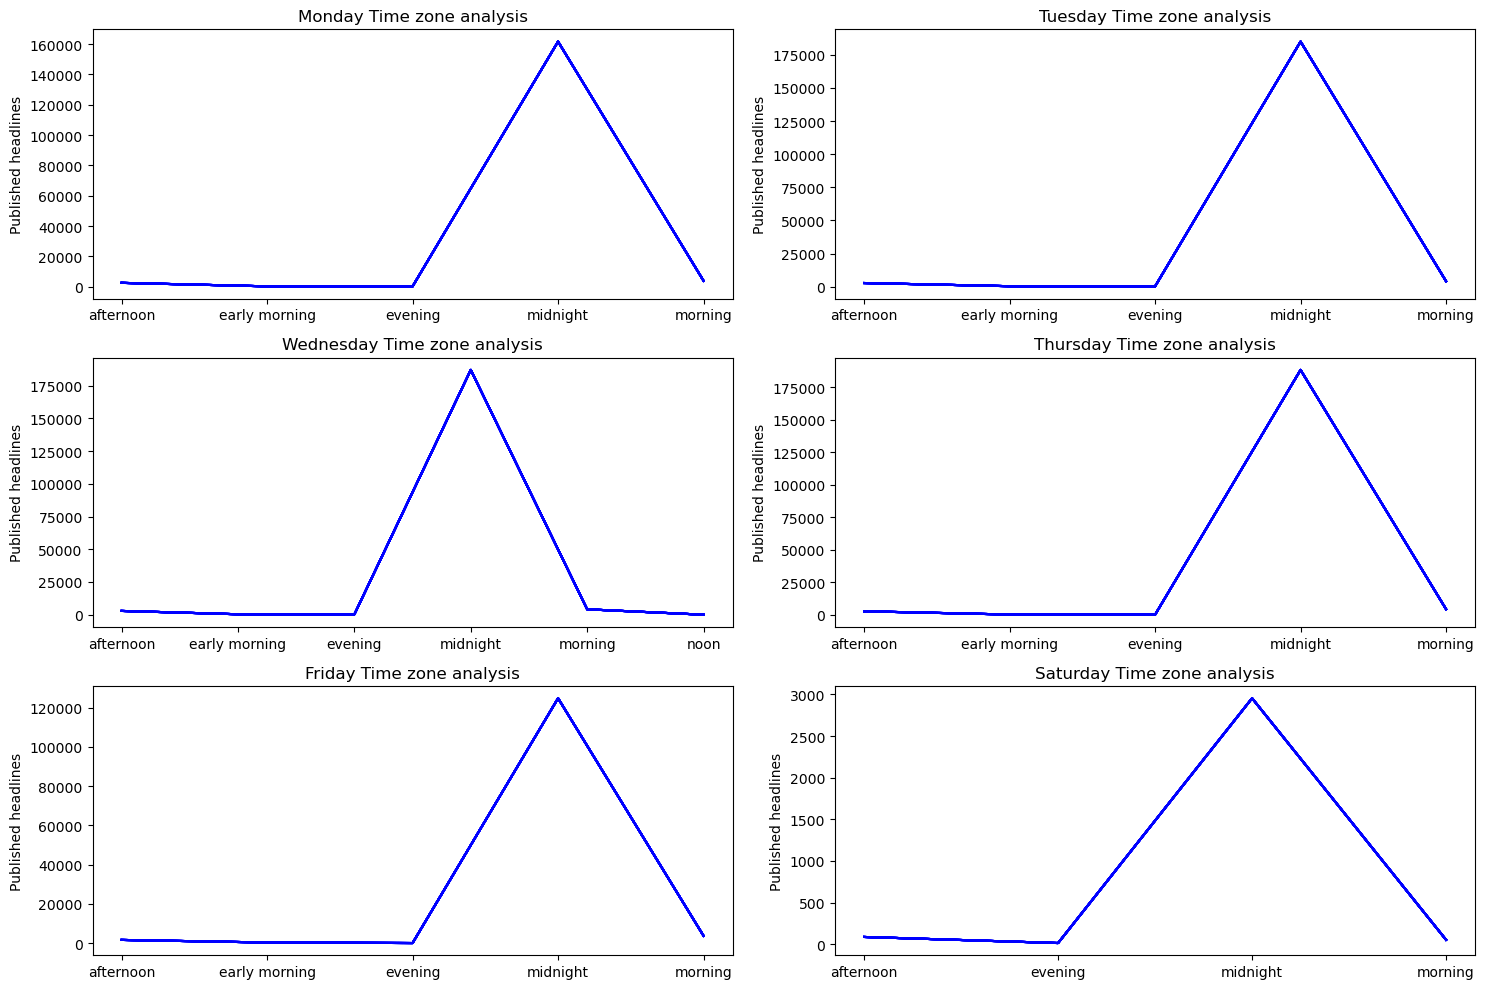

In [36]:
# time zones per day analysis
day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday'] # from the above graphs Saturday and Sunday has the lowes headline publishes

fig, axs = plt.subplots(3,2,figsize = (15,10))
axs = axs.flatten()

for i,d in enumerate(day):
    df = df_cleaned[df_cleaned['day_name'] == d].groupby('time_category').count() # group the dataframe by day name
    x = df.index.tolist()
    y = df.values
    
    axs[i].plot(x, y,color = 'b')
    axs[i].set_title(d + ' Time zone analysis')
    axs[i].set_ylabel('Published headlines')
    
plt.tight_layout()
plt.show()

# Publisher analysis

In [37]:
# top 10 publishers
df_cleaned['publisher'].value_counts().head(4)

publisher
Paul Quintaro        211677
Benzinga Newsdesk     95479
Charles Gross         83764
Eddie Staley          54172
Name: count, dtype: int64

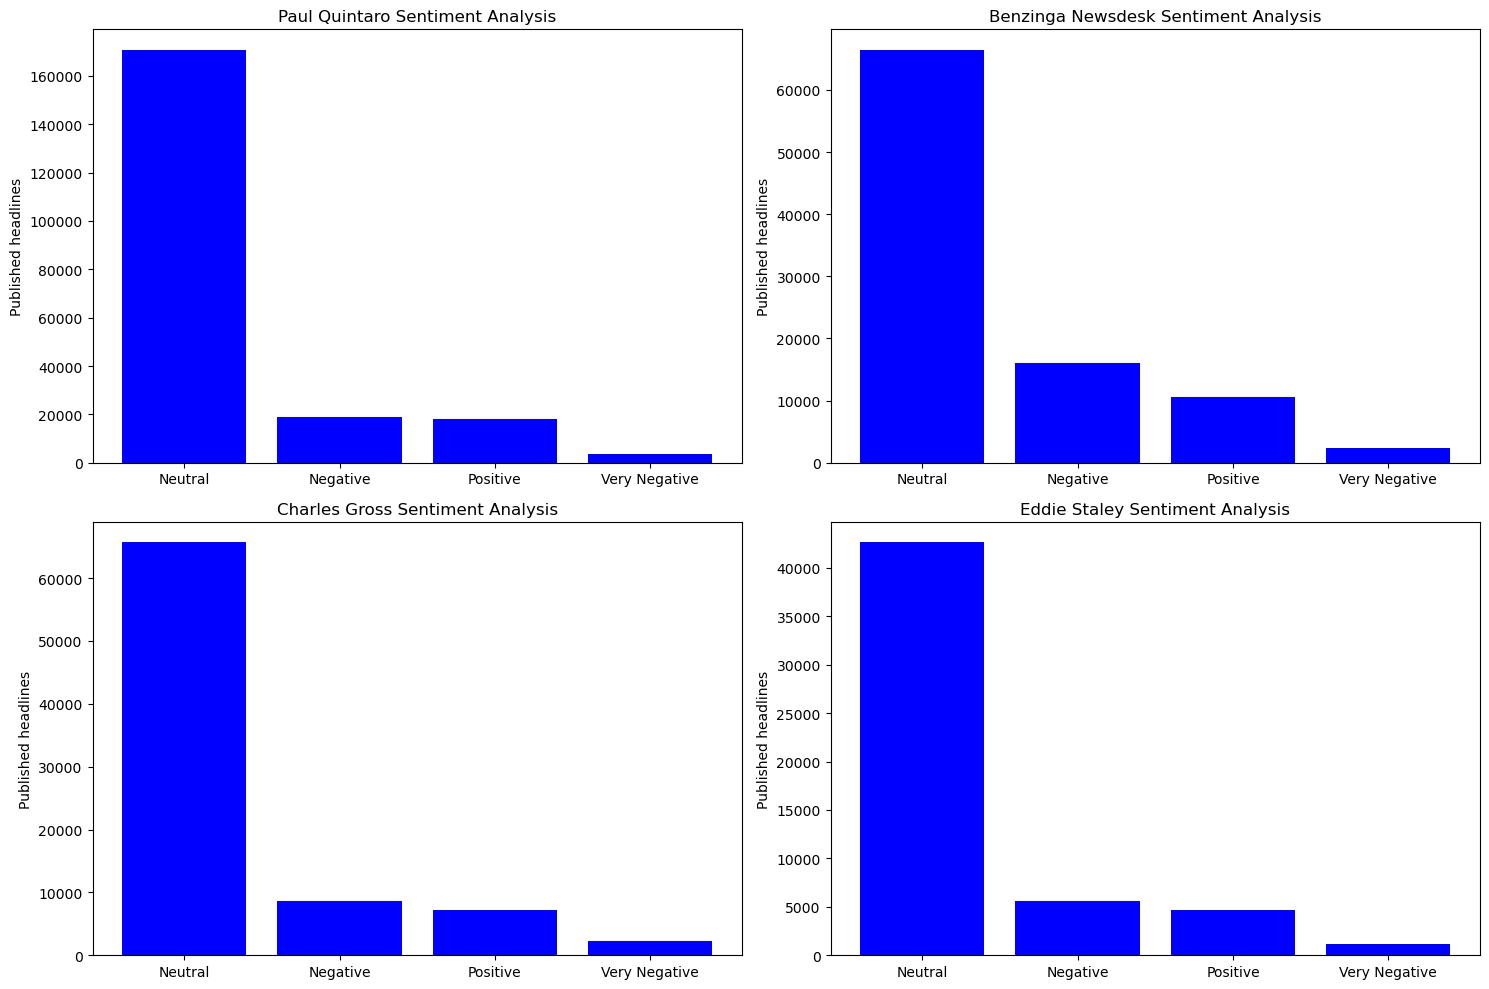

In [38]:
# sentiments of the headlines of the top publisher publishes
top_fourPublishers = ['Paul Quintaro','Benzinga Newsdesk','Charles Gross','Eddie Staley']

fig, axs = plt.subplots(2,2,figsize = (15,10))
axs = axs.flatten()

for i, p in enumerate(top_fourPublishers):
    df = df_cleaned[df_cleaned['publisher'] == p]
    df_count = df['sentiment_category'].value_counts()

    x = df_count.index.tolist()
    y = df_count.values

    axs[i].bar(x, y,color = 'b')
    axs[i].set_title(p + ' Sentiment Analysis')
    axs[i].set_ylabel('Published headlines')    

plt.tight_layout()
plt.show()

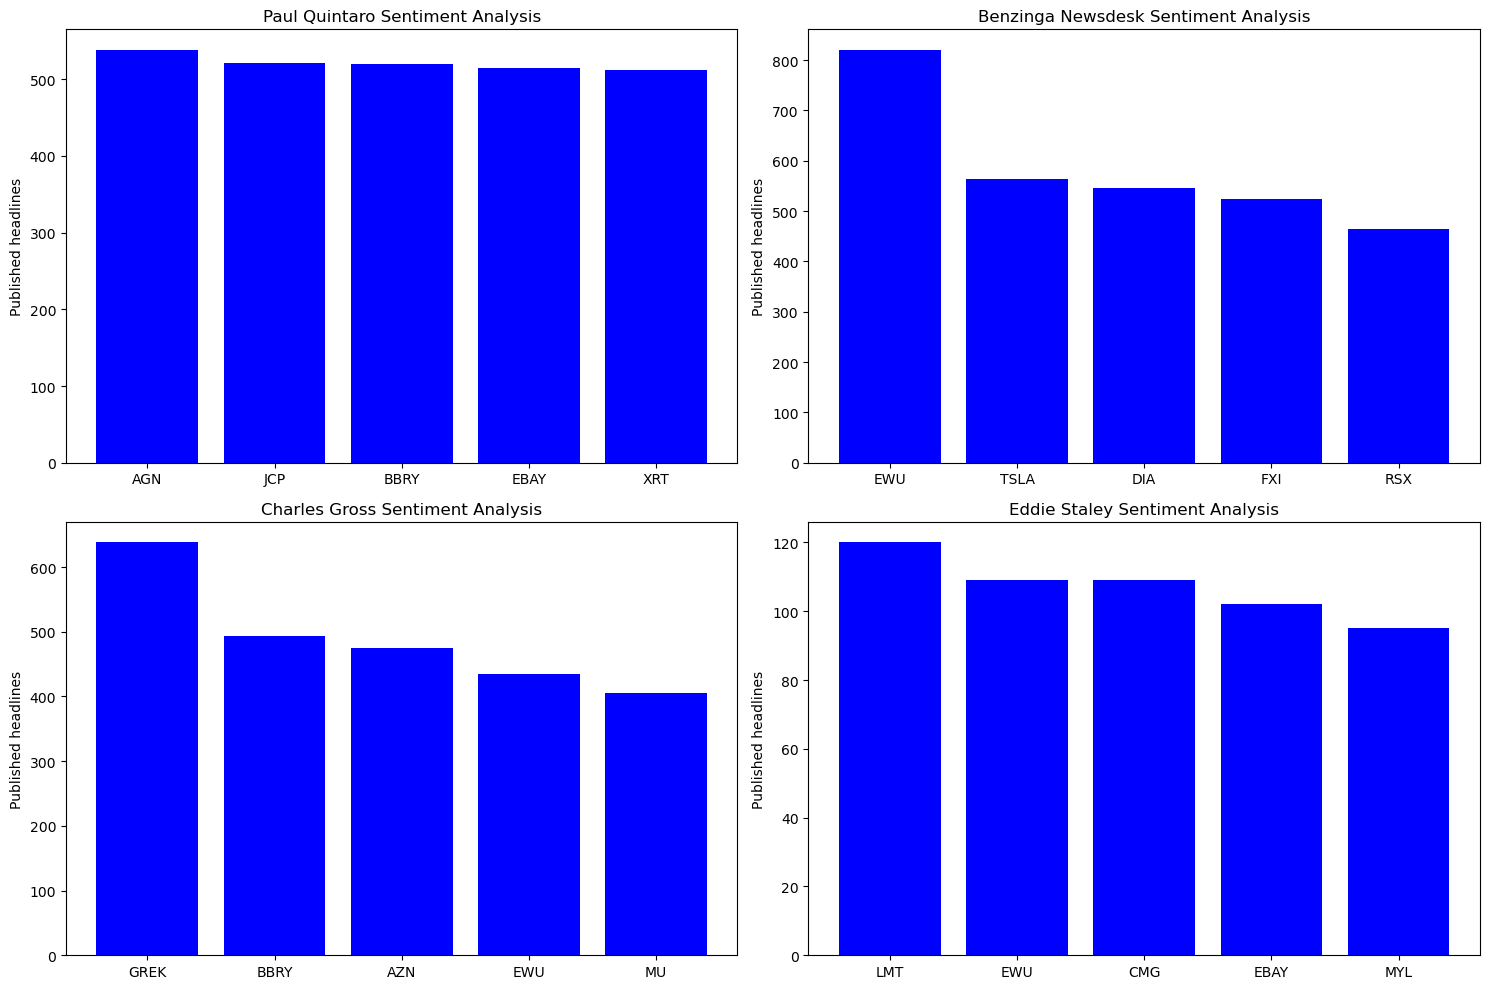

In [39]:
# top 5 publicly traded companies headlines published by the top 4 publishers
fig, axs = plt.subplots(2,2,figsize = (15,10))
axs = axs.flatten()

for i, p in enumerate(top_fourPublishers):
    df = df_cleaned[df_cleaned['publisher'] == p]
    df_count = df['stock'].value_counts().head(5)

    x = df_count.index.tolist()
    y = df_count.values

    axs[i].bar(x, y,color = 'b')
    axs[i].set_title(p + ' Sentiment Analysis')
    axs[i].set_ylabel('Published headlines')    

plt.tight_layout()
plt.show()

In [40]:
# selecting stock only in task 2
task2_stocks = ['AAPL','AMZN','GOOG','META','MSFT','NVDA','TSLA']
df_cleaned_tocsv = df_cleaned[df_cleaned['stock'].isin(task2_stocks)]

In [41]:
# export to csv file
df_cleaned_tocsv.to_csv('stock_news', index = False)